# Extracting cardiorespiratory patterns
This Notebook illustrates a change in `epoch_create()` to PR for.

### Motivation : 
Generaly, research in psychophysiology shows that we can, by measuring HRV with ECG, have an proxy for Autonomic Nervous system activity [Polyvagal theory](https://books.google.ca/books?hl=fr&lr=&id=0-nxBGHj36oC&oi=fnd&pg=PR9&dq=porges+polyvagal+theory&ots=tfyHjgm8hm&sig=TtU2kkgwUG-29Tlx1UCKeH5nBWM#v=onepage&q=porges%20polyvagal%20theory&f=false), [Neurovisceral Integration Model](https://www.researchgate.net/publication/285225132_Heart_Rate_Variability_A_Neurovisceral_Integration_Model). 

*Most research just may underestimate*:
1. how hard it is to infer **Parasympathetic and Sympathetic** activity. You need respiration! 
2. how deep and meaningful their interactions with Brain activity and psychological functions are.

In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# change plotting parameters
sns.set_style('darkgrid')

In [2]:
from neurokit2.events.events_find import _events_find_label
from neurokit2.misc import listify

In [3]:
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size'] = 12

## Download the dataset located on the GitHub repository. 

It contains 2.5 minutes of biosignals recorded at a frequency of 100Hz (2.5 x 60 x 100 = 15000 data points).

Biosignals : **ECG, RSP, EDA + Photosensor (event signal)**

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/neuropsychology/NeuroKit/master/data/example_bio_100hz.csv")

## Process RSP and ECG only

`bio_process` runs the main function, all default pipeline.

In [5]:
bio_df, bio_info = nk.bio_process(ecg=data['ECG'], rsp=data['RSP'], sampling_rate=100)

## Find the begining of RSP cycle

In [6]:
events = nk.events_find(bio_df['RSP_Troughs'])

In [7]:
events

{'onset': array([  343,   753,  1104,  1501,  1791,  2140,  2430,  2727,  3032,
         3314,  3687,  3991,  4270,  4695,  5117,  5454,  5759,  6053,
         6347,  6636,  7343,  7660,  7992,  8333,  8566,  8965,  9271,
         9611,  9938, 10286, 10605, 10905, 11216, 11543, 12454, 12876,
        13290, 13618, 13866, 14289]),
 'duration': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'label': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
        '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
        '35', '36', '37', '38', '39', '40'], dtype='<U11')}

See default `events['duration']` is `epoch_end` default parameter in `epoch_create()`


In [8]:
events['duration'] = events['onset'][1:]-events['onset'][:-1]

The duration I'm interested in is **the interval** between `RSP_Troughs`. Its **length is variable.**

In [9]:
# but, now 'duration' and 'onset' arrays are not of equal shape so 
# add first 'onset' (in nb of samples) to 'duration' first position
events['duration'] = np.insert(events["duration"], 0, events["onset"][0])

In [10]:
events

{'onset': array([  343,   753,  1104,  1501,  1791,  2140,  2430,  2727,  3032,
         3314,  3687,  3991,  4270,  4695,  5117,  5454,  5759,  6053,
         6347,  6636,  7343,  7660,  7992,  8333,  8566,  8965,  9271,
         9611,  9938, 10286, 10605, 10905, 11216, 11543, 12454, 12876,
        13290, 13618, 13866, 14289]),
 'duration': array([343, 410, 351, 397, 290, 349, 290, 297, 305, 282, 373, 304, 279,
        425, 422, 337, 305, 294, 294, 289, 707, 317, 332, 341, 233, 399,
        306, 340, 327, 348, 319, 300, 311, 327, 911, 422, 414, 328, 248,
        423]),
 'label': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
        '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
        '35', '36', '37', '38', '39', '40'], dtype='<U11')}

## Events were correctly found, but now, we have duration

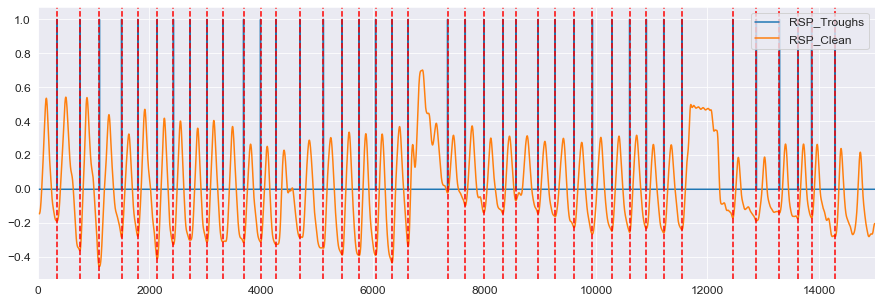

In [11]:
Cycles = nk.events_plot(events, signal=bio_df[['RSP_Troughs', 'RSP_Clean']])

*NOTES:* big peaks look like noise to me, but may be caused by big increase in amplitude

## Create epochs with variable durations
`phys_event` is False by default. But in the case that the event is physiological activity, you can specify `True`to create epochs based on the duration of the cycle.

In [12]:
rsp_period = nk.epochs_create(bio_df, bio_info['RSP_Troughs'],phys_event=True, 
                              sampling_rate=100)

In [13]:
# select a sub sample of breathing cycle
sub_sample = list(events['label'][25:])

#### Plot the last of them

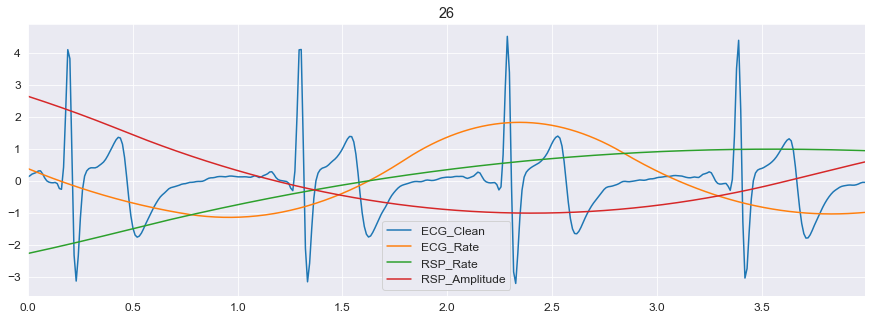

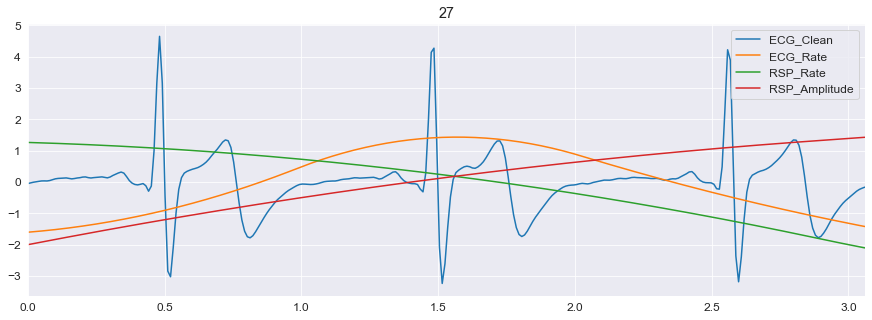

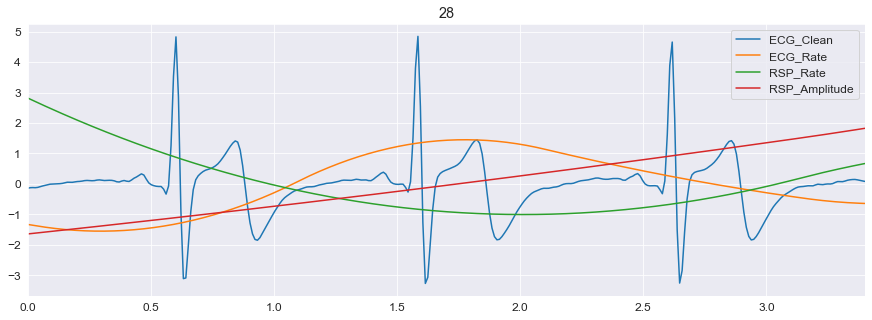

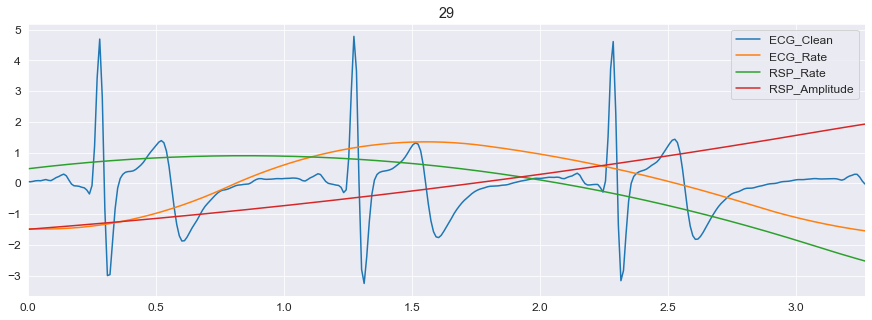

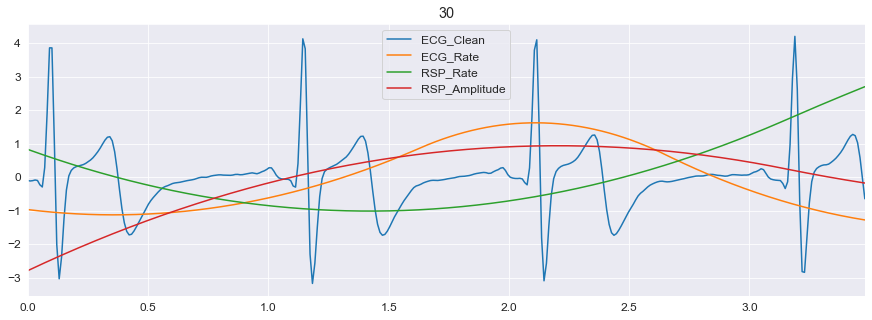

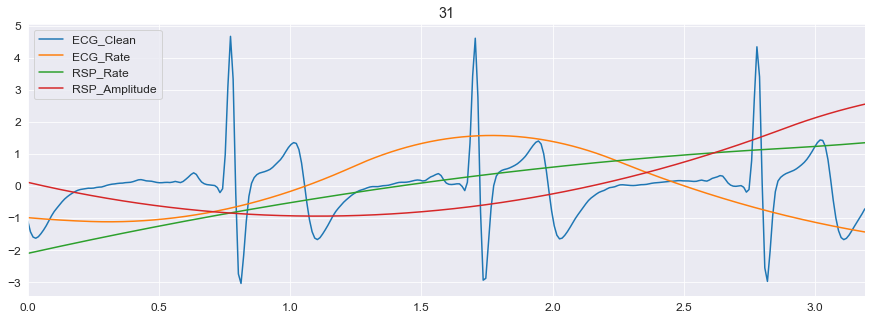

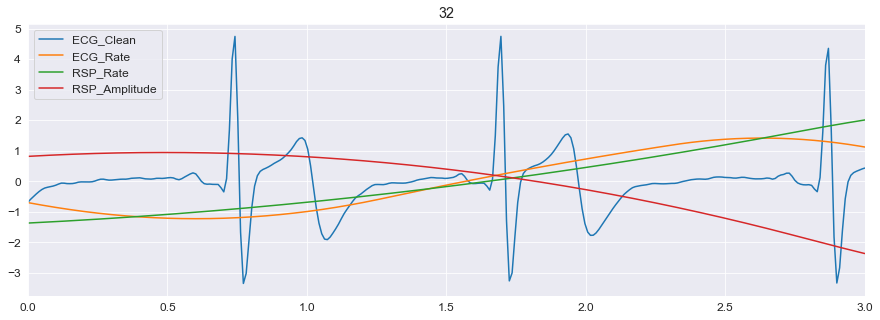

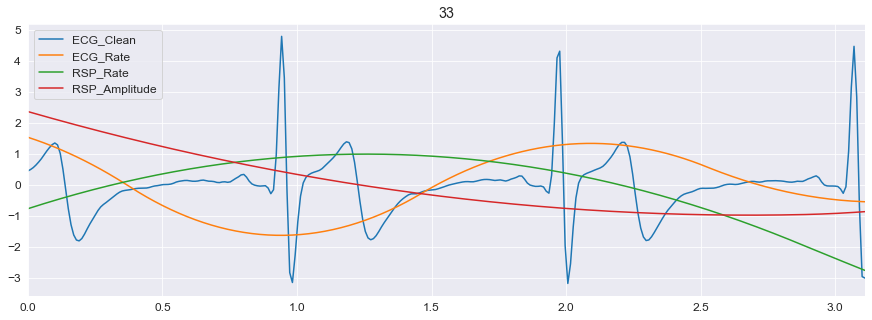

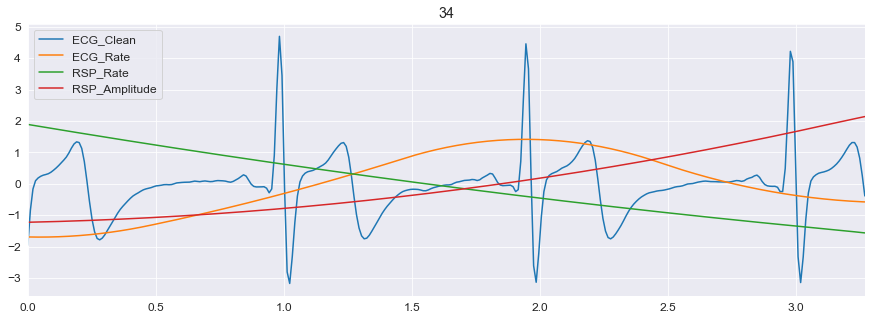

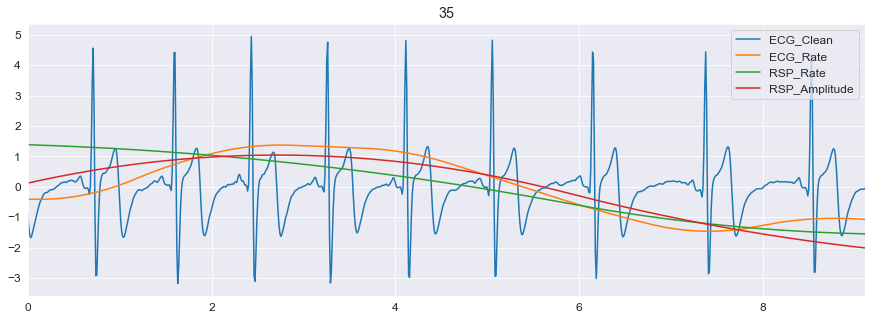

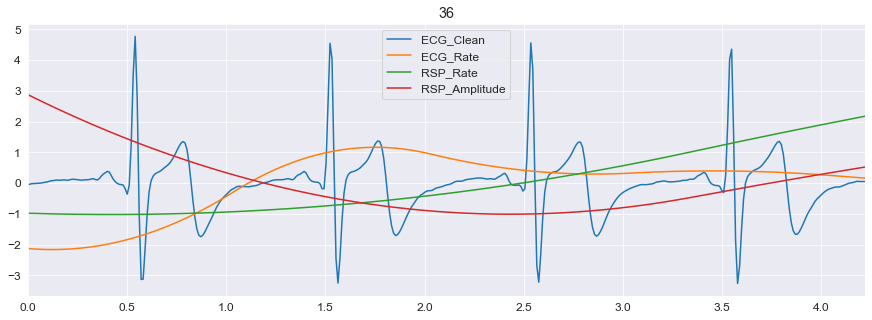

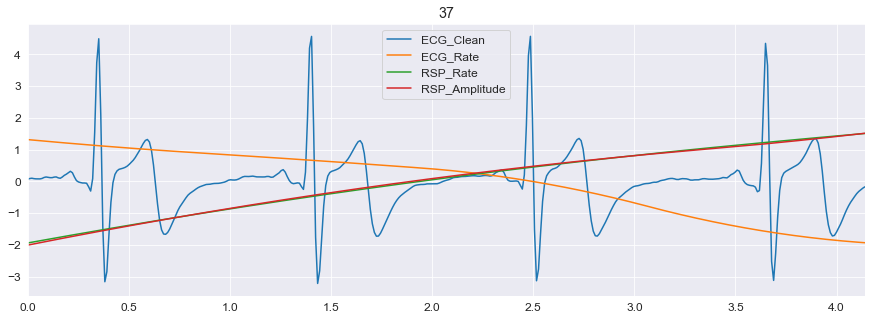

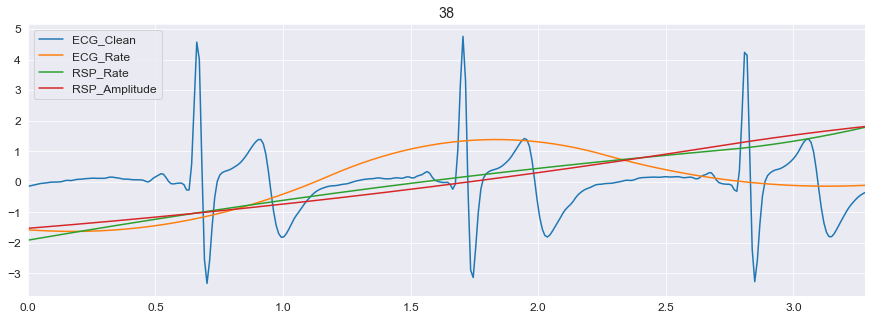

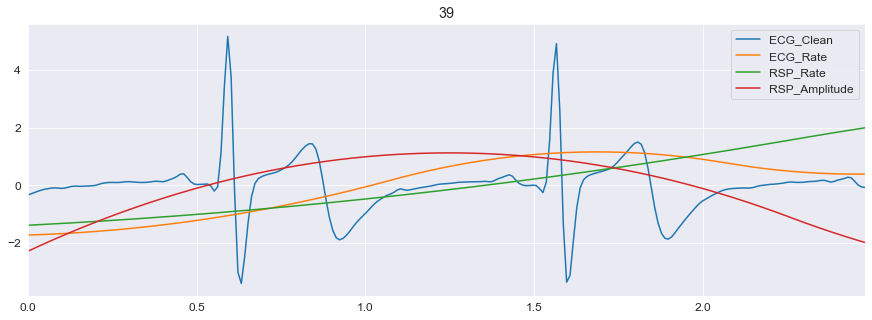

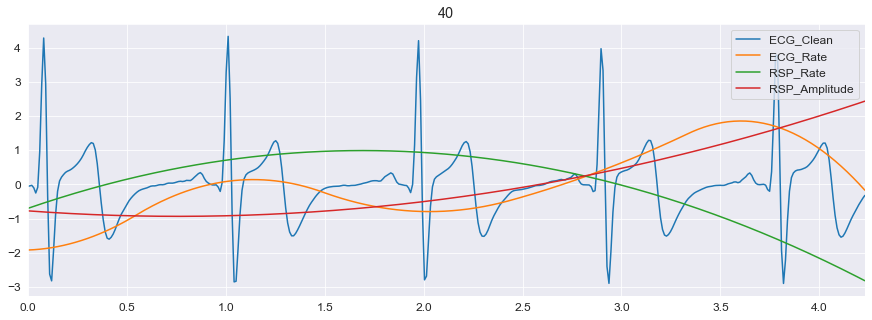

In [14]:
for i, epoch in enumerate (sub_sample):
    
    epoch = rsp_period[epoch]  # iterate cycles
    epoch = epoch[['ECG_Clean', 'ECG_Rate', 'RSP_Rate', 'RSP_Amplitude']]
    
    title = sub_sample[i] # get title from condition list",
    
    nk.standardize(epoch).plot(title=title, legend=True)  # Plot scaled signals"

*NOTES*: Respiration cycle `35` looks fine eventhough it seemed problematic. **I assume it because other signals are clean**. 

> Definitely, someone should code and inter-biosignal noise check in `bio_process()`

## Now we can really tap into cardiorespiratory patterns
See the relation between `RSP_Rate` and `ECG_Rate` ? What's the implication of breathing amplitude on heart rate ? We have to investigate it, am I right !?

You may have heard or read that LF/HF ratio of HRV reflects sympatho-vagal balance. Well, this idea is **revoked by many researchers** (here's two essentials : [Shaffer et al. 2017](https://www.ncbi.nlm.nih.gov/pubmed/29034226), [Quintana, Alvarez & Heathers, 2016 - GRAPH](https://www.ncbi.nlm.nih.gov/pubmed/27163204)). Basically, HF band HRV (0.15-0.4 Hz) is greatly affected by respiration. So no easy way to isolate parasympathetic cardiac activity but to measure respiration. More to come...

> On basic emotions distinctive cardiorespiratory patterns :
[Rainville, Bechara, Navqi & Damasio, 2006](https://www.sciencedirect.com/science/article/pii/S0167876005002801)